# SkimLit

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Purpose of this notebook to build an NLP Model to make reading medical abtracts easier.

## Importing Data

In [2]:
!ls pubmed-rct-master/PubMed_20k_RCT

ls: cannot access 'pubmed-rct-master/PubMed_20k_RCT': No such file or directory


In [3]:
!ls pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign

ls: cannot access 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign': No such file or directory


### Starting our experiment with 20K data

In [4]:
data_dir = "/content/drive/MyDrive/SkimLit/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
#Checking all the files in the data directory
import os
filenames = [os.path.join(data_dir,filename) for filename in os.listdir(data_dir)]
filenames

['/content/drive/MyDrive/SkimLit/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/drive/MyDrive/SkimLit/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/drive/MyDrive/SkimLit/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

In [6]:
#Creating a function to read the lines from the document
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
#reading the train data
train_lines = get_lines(os.path.join(data_dir, 'train.txt'))
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
## Convert the train_lines to store in dictionary
train_lines[0]

'###24293578\n'

In [10]:
train_lines[1]

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'

In [11]:
train_lines[4].split('\t')

['METHODS',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [12]:
train_dict = {}
total_lines = 0
for line in train_lines:
    if line[:3] == '###' and line[4].isdigit() :
        line_number = line[3:]
        total_lines=0
    elif line != '\n':
        text, target = line.split('\t')
        total_lines+=1



In [13]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ''
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
        else:
            abstract_lines+=line

    return abstract_samples


In [14]:
%%time
train_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, 'train.txt'))
test_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, 'test.txt'))
val_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, 'dev.txt'))

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 427 ms, sys: 119 ms, total: 546 ms
Wall time: 2.62 s


(180040, 30212, 30135)

In [15]:
train_samples[:13]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [16]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [17]:
#Distribution of labels in training data
train_df['target'].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


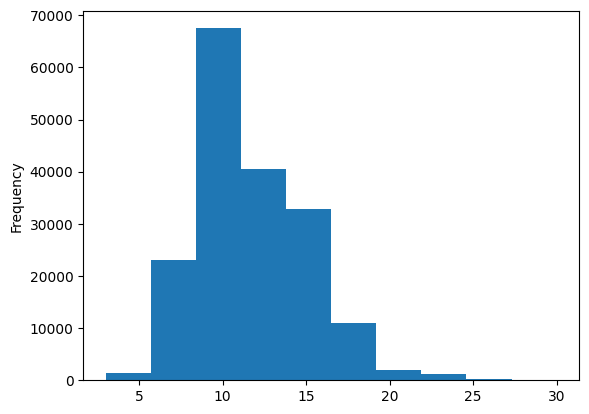

In [18]:
#Visualize the total_lines
import matplotlib.pyplot as plt
train_df['total_lines'].plot(kind='hist')
plt.show()

### Lets get list of sentences

In [19]:
# Convert abstract text into list of sentences
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

In [20]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Converting target labels into numeric values

In [21]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoder.fit(train_df[['target']])
# onehot_encoder(train_df['text'])

OneHotEncoder(sparse_output=False)

In [22]:
train_labels_one_hot = onehot_encoder.transform(train_df[['target']])
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
val_labels_one_hot = onehot_encoder.transform(val_df[['target']])
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
test_labels_one_hot = onehot_encoder.transform(test_df[['target']])
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

### encoding labels using label encoder

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df[['target']])
test_labels_encoded = label_encoder.transform(test_df[['target']])
val_labels_encoded = label_encoder.transform(val_df[['target']])

train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [26]:
#lets check the class names and number of classes
class_names = list(label_encoder.classes_)
num_classes = len(class_names)
num_classes, class_names

(5, ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

## Model_0: Baseline model(Multinomial Naive Bayes Classifier)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from helper_functions import *

In [28]:
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
#evaluating the model on val data
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [30]:
#making baseline predictions on the val data
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [31]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_1: Convolutional 1D Model

### Preparing the text data for deep sequence models

In [32]:
import tensorflow as tf

In [33]:
#average length of the setences
sentence_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sentence_lens)
avg_sent_len

26.338269273494777

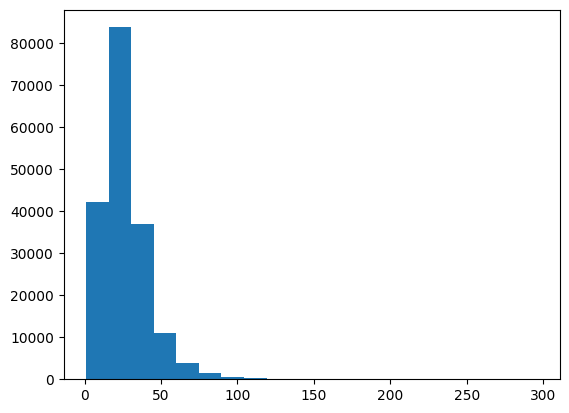

In [34]:
plt.hist(sentence_lens, bins= 20)
plt.show()

In [35]:
#lets check length that covers 95% of the sentences
output_seq_len = np.percentile(sentence_lens, 95)
output_seq_len

55.0

In [36]:
max(sentence_lens)

296

In [37]:
vocab = []
for sentence in train_sentences:
    vocab+=sentence.split()
len(set(vocab))

69732

In [38]:
max_vocab_tokens = 68000
max_length = 55

In [39]:
#text vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_vocab_tokens,
                                                    output_sequence_length = max_length,
                                                    output_mode = 'int')

text_vectorizer.adapt(train_sentences)

In [40]:
#checking the random text and its vector representation
import random
text = random.choice(train_sentences)
text_vector  = text_vectorizer(text)

print(f'Text: {text}\n\nLength of text: {len(text.split())} \n\nText Vector: {text_vector} \n\nLength of Text Vector: {len(text_vector)}')

Text: to evaluate the short-term effect on spinal mobility , pain perception , neural mechanosensitivity , and full height recovery after high-velocity , low-amplitude ( hvla ) spinal manipulation ( sm ) in the lumbosacral joint ( l@-s@ ) .

Length of text: 39 

Text Vector: [    6   164     2   854    70    18   841  1584    65  1569  3077 20208
     3  1186  1346   393    21 30923 30312 20478   841  2148  6255     5
     2  8236  1060  3172     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] 

Length of Text Vector: 55


In [41]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Total words in the vocabulary: {len(rct_20k_text_vocab)}\n')
print(f'Top 5 Most repeated words: {rct_20k_text_vocab[:5]}\n')
print(f'Top 5 Least repeated words: {rct_20k_text_vocab[-5:]}')

Total words in the vocabulary: 64841

Top 5 Most repeated words: ['', '[UNK]', 'the', 'and', 'of']

Top 5 Least repeated words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [42]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom embedding

In [43]:
#creating the token embedding layer
token_embed = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                        output_dim = 128,
                                        mask_zero = True,
                                        name = 'token_embedding'                                        )

In [44]:
#example for all the previous steps
print(f'Sentence in the beginning: {text}\n\n')
vectorized_text = text_vectorizer(text)
print(f'Sentence after vectorization: {vectorized_text} \n\nShape of the vectorized text :{vectorized_text.shape} \n\n')
embedded_text = token_embed(vectorized_text)
print(f'Sentence after vectorization and embeddings: {embedded_text} \n\nShape of the embedded text:{embedded_text.shape}')

Sentence in the beginning: to evaluate the short-term effect on spinal mobility , pain perception , neural mechanosensitivity , and full height recovery after high-velocity , low-amplitude ( hvla ) spinal manipulation ( sm ) in the lumbosacral joint ( l@-s@ ) .


Sentence after vectorization: [    6   164     2   854    70    18   841  1584    65  1569  3077 20208
     3  1186  1346   393    21 30923 30312 20478   841  2148  6255     5
     2  8236  1060  3172     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] 

Shape of the vectorized text :(55,) 


Sentence after vectorization and embeddings: [[ 0.04365974  0.04795695 -0.00497102 ...  0.01531324  0.0480342
  -0.00571525]
 [ 0.02817992  0.00656221  0.01843179 ...  0.02613581  0.01658252
   0.01708113]
 [-0.01321738  0.0389969   0.04553474 ... -0.03501097  0.04256116
   0.00634924]
 ...
 [-0.01315702  0.04736877 -0.02332714

### Turning the data to Tensorflow Datasets

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [46]:
#Conveting tensorflowDatasets to prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [47]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x= token_embed(x)
x = tf.keras.layers.Conv1D(filters = 64,
                           kernel_size = 5,
                           strides = 1,
                           padding='valid',
                           activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 51, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history_1 = model_1.fit(train_dataset,
            steps_per_epoch = int(0.1 * len(train_dataset)),
            validation_data = val_dataset,
            validation_steps = int(0.1 * len(val_dataset)),
            epochs = 3)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5126 - loss: 1.1865 - val_accuracy: 0.7168 - val_loss: 0.7340
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7351 - loss: 0.7165 - val_accuracy: 0.7537 - val_loss: 0.6620
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7598 - loss: 0.6499 - val_accuracy: 0.7866 - val_loss: 0.6106


In [49]:
#Lets evaluate the model_1
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7785 - loss: 0.6186


[0.6203563213348389, 0.7792599201202393]

In [50]:
#lets make the predictions of the validation data
model_1_preds = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_preds, axis=1)
model_1_preds

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [51]:
#lets generate results from the model_1
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 77.92598967297762,
 'precision': 0.7755559275560444,
 'recall': 0.7792598967297762,
 'f1': 0.7762603588470639}

## Model_2: Feature extraction with pretrained token embedding

In [52]:
import tensorflow_hub as hub
import tf_keras

In [53]:
#Downloading the pre trained Universal Sentence Encoder
use_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     trainable=False,
                                     name= 'USE_encoder')

In [54]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [55]:
random_train_sentence = random.choice(train_sentences)
print(f'Random Sentence: {random_train_sentence}\n')
embedded_random_train_sentence = use_embedding_layer([train_sentences[0]])
print(f'Random Sentence after embedding: {embedded_random_train_sentence[0]}\n')
print(f'Length of the Sentence after embedding: {len(embedded_random_train_sentence[0])}')


Random Sentence: to investigate the renoprotective effect of nicardipine in patients with pre-existing renal insufficiency undergoing robot-assisted laparoscopic radical prostatectomy ( ralrp ) .

Random Sentence after embedding: [-4.90380153e-02  5.24623357e-02  3.95998545e-02 -6.31776452e-02
 -7.30676949e-02  6.28731400e-02  3.52798924e-02 -6.18203953e-02
  5.71083017e-02  4.63245288e-02  7.16570467e-02  2.51984107e-03
 -9.52069461e-03  6.51002629e-03  3.80009003e-02  3.74653898e-02
 -7.96469226e-02  6.41185567e-02  3.50537635e-02 -3.88272963e-02
  1.50760226e-02 -1.20223174e-02  1.47859277e-02 -2.70261429e-02
  1.51410466e-02  5.35054170e-02 -6.14334876e-03 -3.47358324e-02
 -7.48624504e-02  2.86216103e-03 -5.25581725e-02  7.89910331e-02
  7.17563331e-02  1.59457736e-02 -6.31276146e-02  1.22191589e-02
 -1.35266166e-02 -3.82611081e-02 -1.69011764e-02 -6.66884333e-02
 -4.18503881e-02  7.29317218e-02 -1.60359014e-02 -5.26477359e-02
  6.90131113e-02  6.53062165e-02 -3.43542360e-02 -3.795

In [56]:
inputs = tf_keras.layers.Input(shape=[], dtype=tf.string)
x = use_embedding_layer(inputs)
x = tf_keras.layers.Dense(128, activation='relu')(x)
outputs = tf_keras.layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf_keras.Model(inputs, outputs)

model_2.compile(loss= 'categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [57]:
history_2 = model_2.fit(train_dataset,
            epochs = 3,
            steps_per_epoch= int(0.1* len(train_dataset)),
            validation_data=val_dataset,
            validation_steps=int(0.1* len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9173 - accuracy: 0.6501 - val_loss: 0.7958 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 6s 12ms/step - loss: 0.7678 - accuracy: 0.7013 - val_loss: 0.7552 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7517 - accuracy: 0.7130 - val_loss: 0.7390 - val_accuracy: 0.7114


In [58]:
#evaluating the model
model_2.evaluate(val_dataset)

945/945 [==============================] - 14s 14ms/step - loss: 0.7406 - accuracy: 0.7154


[0.7405749559402466, 0.7154110670089722]

In [59]:
#Making predictions using the model
model_2_preds = model_2.predict(val_sentences)
model_2_preds = tf.argmax(model_2_preds, axis=1)
model_2_preds

945/945 [==============================] - 19s 19ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
#calculating the results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.54110949291672,
 'precision': 0.7158893820119483,
 'recall': 0.7154110949291672,
 'f1': 0.7124440733699479}

In [61]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_3: Conv1D with Character embeddings   

### Creating character level tokenizer

In [62]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [63]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [64]:
#creating function to split sentence into chars
def split_chars(text):
    return " ".join(list(text))

#splitting the sentence into characters
import random
random_train_sentence = random.choice(train_sentences)
split_chars(random_train_sentence)

'i n d i v i d u a l s   t r e a t e d   w i t h   t h e   c h o l e s t e r y l   e s t e r   t r a n s f e r   p r o t e i n   (   c e t p   )   i n h i b i t o r   a n a c e t r a p i b   e x h i b i t   a   r e d u c t i o n   i n   b o t h   l d l   c h o l e s t e r o l   a n d   a p o l i p o p r o t e i n   b   (   a p o b   )   i n   r e s p o n s e   t o   m o n o t h e r a p y   o r   c o m b i n a t i o n   t h e r a p y   w i t h   a   s t a t i n   .'

In [65]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:1]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .']

In [66]:
#char lens
char_lens = [len(sentence) for sentence in train_chars]
avg_char_len = np.mean(char_lens)
avg_char_len

297.7325149966674

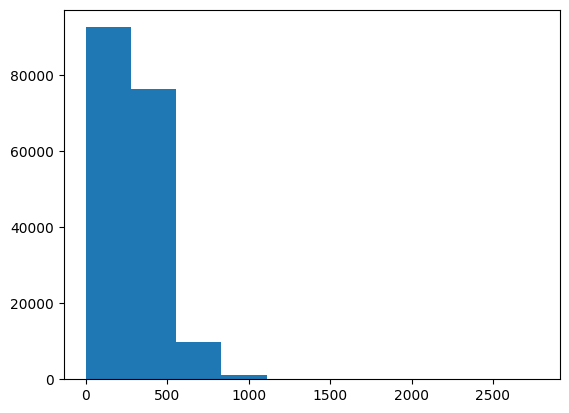

In [67]:
#checking the distribution of the sequences at character level
plt.hist(char_lens)
plt.show()

In [68]:
#sequence char length to cover 95% of the sequences
output_seq_len = int(np.percentile(char_lens,95))
output_seq_len

579

In [69]:
# all characters
import string

alphabet = string.ascii_lowercase + string.digits+ string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #adding 2 for space and OOV token (Out of Vocab '[UNK]')

char_tokenizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                   output_sequence_length = output_seq_len,
                                   name = 'char_tokenizer')

#adapting the vectorizer to training character
char_tokenizer.adapt(train_chars)

In [71]:
char_vocab = char_tokenizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}\n')
print(f'5 Most common characters: {char_vocab[:5]}\n')
print(f'5 Least common characters: {char_vocab[-5:]}\n')
# char_vocab

Number of different characters in character vocab: 28

5 Most common characters: ['', '[UNK]', 'e', 't', 'i']

5 Least common characters: ['k', 'x', 'z', 'q', 'j']



In [72]:
#Testing out character level vectorizer
random_train_char = random.choice(train_chars)
print(f"character level sentence: {random_train_char}\n")
print(f"Length of the random_train_char: {len(random_train_char)}")

vectorized_random_train_char = char_tokenizer(random_train_char)
print(f"Vectorized random_train_char: {vectorized_random_train_char}\n")
print(f"Length of the vectorized random_train_char:{len(vectorized_random_train_char)}")
# vectorized_random_train_char


character level sentence: c o m p a r e d   w i t h   s e n s o r - a u g m e n t e d   p u m p   t h e r a p y   ,   c l c   i m p r o v e d   s i g n i f i c a n t l y   t i m e   s p e n t   b e t w e e n   @   a n d   @ m g / d l   (   @   %   v s .   @   %   ;   p   <   @   )   a n d   b e t w e e n   @   a n d   @ m g / d l   (   @   %   v s .   @   %   ;   p   <   @   )   ;   c l c   r e d u c e d   t h e   m e a n   g l u c o s e   l e v e l   a t   @ : @   h   (   @   v s .   @   m g / d l   ;   p   <   @   )   a n d   o v e r n i g h t   m e a n   g l u c o s e   l e v e l   (   @   v s .   @   m g / d l   ;   p   <   @   )   u s i n g   a   m a r g i n a l l y   l o w e r   a m o u n t   o f   i n s u l i n   (   @   v s .   @   u n i t s   ;   p   =   @   )   .

Length of the random_train_char: 757
Vectorized random_train_char: [11  7 15 14  5  8  2 10 20  4  3 13  9  2  6  9  7  8  5 16 18 15  2  6
  3  2 10 14 16 15 14  3 13  2  8  5 14 19 11 12 11  4 15 14  8  7 21  2
 1

### Creating character level Embedding

In [73]:
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                       output_dim=25, #this can be flexible and we are using the same value from the paper
                                       mask_zero = True,
                                       name='embedding_layer')

In [74]:
#Testing the char tokenizer and embeddings
random_train_char = random.choice(train_chars)
print(f'Random train chars: {random_train_char}\n')
vectorized_random_train_char = char_tokenizer(random_train_char)
print(f"After vectorizing the random train chars: {vectorized_random_train_char}\n")
print(f'Shape of the random train chars after Vectorization: {vectorized_random_train_char.shape}\n')
embed_random_train_char = char_embed(vectorized_random_train_char)
print(f"After Vectorizing & Embedding random train chars: {embed_random_train_char}\n")
print(f"Shape of the random train chars after Vectorization & Embedding: {embed_random_train_char.shape}")

Random train chars: d i s r u p t   e v a l u a t e d   w h e t h e r   a d d i n g   t h e   v a s c u l a r - d i s r u p t i n g   a g e n t   o m b r a b u l i n   t o   a   t a x a n e - p l a t i n u m   d o u b l e t   i n   t h e   f i r s t - l i n e   s e t t i n g   i m p r o v e d   p r o g r e s s i o n - f r e e   s u r v i v a l   (   p f s   )   i n   p a t i e n t s   w i t h   m e t a s t a t i c   n o n - s m a l l   c e l l   l u n g   c a n c e r   (   n s c l c   )   .

After vectorizing the random train chars: [10  4  9  8 16 14  3  2 21  5 12 16  5  3  2 10 20 13  2  3 13  2  8  5
 10 10  4  6 18  3 13  2 21  5  9 11 16 12  5  8 10  4  9  8 16 14  3  4
  6 18  5 18  2  6  3  7 15 22  8  5 22 16 12  4  6  3  7  5  3  5 24  5
  6  2 14 12  5  3  4  6 16 15 10  7 16 22 12  2  3  4  6  3 13  2 17  4
  8  9  3 12  4  6  2  9  2  3  3  4  6 18  4 15 14  8  7 21  2 10 14  8
  7 18  8  2  9  9  4  7  6 17  8  2  2  9 16  8 21  4 21  5 12 14 17  9
  4  6 14  5  3  4  2  

In [75]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_tokenizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(filters = 64,
                           kernel_size=5,
                           strides=1,
                           padding='valid',
                           activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy']
                )

model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_tokenizer (TextVectorization)   │ (None, 579)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (Embedding)          │ (None, 579, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 575, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
#Lets create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
history_3 = model_3.fit(train_char_dataset,
            steps_per_epoch = int(0.1 * len(train_char_dataset)),
            epochs = 3,
            validation_data = val_char_dataset,
            validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3280 - loss: 1.4792 - val_accuracy: 0.4072 - val_loss: 1.4116
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4196 - loss: 1.3954 - val_accuracy: 0.4548 - val_loss: 1.3347
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4423 - loss: 1.3544 - val_accuracy: 0.4465 - val_loss: 1.3355


In [78]:
# Evaluating the model_3
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4474 - loss: 1.3278


[1.3285695314407349, 0.446445107460022]

In [79]:
# Making predictions using model_3
model_3_preds = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_preds,axis=1)
model_3_preds

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 4, 4])>

In [80]:
# calculating the results of model_3
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 44.64451211439163,
 'precision': 0.36979538862118694,
 'recall': 0.4464451211439163,
 'f1': 0.38750617640083274}

## Model_4: Pretrained token embeddings(USE) + character embeddings

In [81]:
# 1. Token inputs & Model
token_inputs = tf_keras.layers.Input(shape=[], dtype = tf.string, name='token_input')
token_embeddings = use_embedding_layer(token_inputs)
token_outputs = tf_keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf_keras.Model(token_inputs, token_outputs)

# 2. Char inputs & Model
char_inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string, name = 'char_input')
char_vectors = tf_keras.layers.Lambda(lambda x: char_tokenizer(x))(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(24))(char_embeddings)
char_model = tf_keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenating the Token and Char Model outputs
token_output = token_model(token_inputs)
char_output = char_model(char_inputs)
combined_model = tf_keras.layers.Concatenate(name='token_char_hybrid')([token_output, char_output])

# 4. Applying the Dropouts to concatenated layers
combined_dropout = tf_keras.layers.Dropout(0.5)(combined_model)
combined_dense = tf_keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf_keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf_keras.layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Combined model
model_4 = tf_keras.Model(inputs = [token_inputs, char_inputs], outputs=output_layer, name='model_4_char_and_token_embeddings')

In [82]:
#Compile the model
model_4.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Combining token and char dataset into tf.data.Dataset

In [83]:
# combining the token and char data
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

# batching and prefetching the data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# applying same steps for the val data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# applying the same steps for test data
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))
test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
# fitting the model on training data
history_4 = model_4.fit(train_token_char_dataset,
validation_data = val_token_char_dataset, epochs = 3,
 steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
 validation_steps = int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 66ms/step - loss: 0.9916 - accuracy: 0.6037 - val_loss: 0.8035 - val_accuracy: 0.6948
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8150 - accuracy: 0.6861 - val_loss: 0.7371 - val_accuracy: 0.7128
Epoch 3/3
562/562 [==============================] - 37s 66ms/step - loss: 0.7870 - accuracy: 0.7021 - val_loss: 0.7093 - val_accuracy: 0.7294


In [85]:
# Evalauting the model on  validation data
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 25s 27ms/step - loss: 0.7144 - accuracy: 0.7243


[0.7143753170967102, 0.7243148684501648]

In [86]:
# making predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs = tf.argmax(model_4_pred_probs,axis=1)
model_4_pred_probs

945/945 [==============================] - 25s 25ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 4, 1])>

In [87]:
model_4_results = calculate_results(val_labels_encoded, model_4_pred_probs)
model_4_results

{'accuracy': 72.43148417847213,
 'precision': 0.7264042264230545,
 'recall': 0.7243148417847213,
 'f1': 0.7212681544387409}

In [88]:
model_1_results

{'accuracy': 77.92598967297762,
 'precision': 0.7755559275560444,
 'recall': 0.7792598967297762,
 'f1': 0.7762603588470639}

In [89]:
model_2_results

{'accuracy': 71.54110949291672,
 'precision': 0.7158893820119483,
 'recall': 0.7154110949291672,
 'f1': 0.7124440733699479}

## Model_5: Pretrained token embeddings + character embeddings + positional embeddings

In [90]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [91]:
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

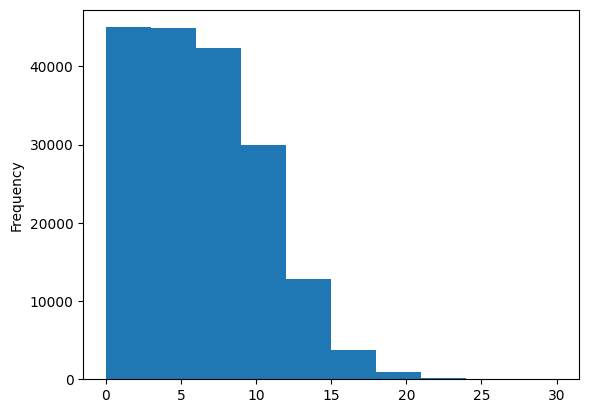

In [92]:
train_df['line_number'].plot(kind='hist')

In [93]:
# one hot encoding the line numbers from train_df
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'], depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'], depth = 15)

In [94]:
train_df['total_lines'].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

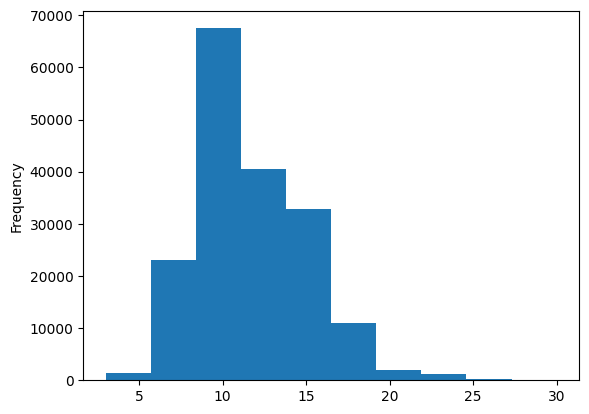

In [95]:
train_df['total_lines'].plot(kind='hist')

In [96]:
np.percentile(train_df['total_lines'],98)

20.0

In [97]:
# one hot encoding the total lines in train_df
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'], depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth = 20)

### building tribrid embedding model

In [98]:
# 1. Token Inputs
token_inputs = tf_keras.layers.Input(shape=[], dtype=tf.string, name = 'token_inputs')
token_embeddings = use_embedding_layer(token_inputs)
token_outputs = tf_keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf_keras.Model(token_inputs, token_outputs)


In [99]:
# 2. Char Inputs
char_inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string, name = 'char_inputs')
char_vectors = tf_keras.layers.Lambda(lambda x : char_tokenizer(x))(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(24))(char_embeddings)
char_model = tf_keras.Model(char_inputs, char_bi_lstm)

In [100]:
# 3. Line Numbers Models
line_number_inputs = tf_keras.layers.Input(shape=(15,), dtype = tf.float32, name='line_number_inputs')
line_number_dense = tf_keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf_keras.Model(line_number_inputs, line_number_dense)

In [101]:
# 4. Total Line Models
total_line_number_inputs = tf_keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_line_number_inputs')
total_line_number_dense = tf_keras.layers.Dense(32, activation='relu')(total_line_number_inputs)
total_line_number_model = tf_keras.Model(total_line_number_inputs, total_line_number_dense)

In [102]:
# 5. Combining token and char embedding into hybrid embedding
token_output = token_model(token_inputs)
char_output = char_model(char_inputs)
combined_embeddings = tf_keras.layers.Concatenate(name='char_token_hybrid_embedding')([token_output, char_output])

In [103]:
z = tf_keras.layers.Dense(256, activation='relu')(combined_embeddings)
z = tf_keras.layers.Dropout(0.5)(z)

In [104]:
# 6. Combining the positional embeddings with hybrid embeddings
line_number_output = line_number_model(line_number_inputs)
total_lines_output = total_line_number_model(total_line_number_inputs)
tribrid_embeddings = tf_keras.layers.Concatenate(name='tribrid_embeddings')([line_number_output, total_lines_output, z])

In [105]:
# 7. Create Output layer
output_layer = tf_keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

In [106]:
# 8. Put together model with all kinds of inputs
model_5 = tf_keras.Model(inputs = [line_number_inputs, total_line_number_inputs, token_inputs, char_inputs],
outputs = output_layer,
name='tribrid_embedding_model_5')

In [107]:
model_5.summary()

Model: "tribrid_embedding_model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 model_3 (Functional)        (None, 128)                  2568634   ['token_inputs[0][0]']        
                                                          88                                      
                                                                                                  
 model_4 (Functional)        (None, 48)                   9600      ['char

In [108]:
# Compiling the token, char & position embedding model
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
optimizer = 'adam', metrics = ['accuracy'])

### Creating tribrid embedding datasets usinf tf.data

In [109]:
# Create training and validataion datasets
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
train_total_lines_one_hot, train_sentences, train_chars))
train_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_char_pos_data, train_token_char_pos_labels))
train_token_char_pos_dataset = train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [110]:
val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
val_total_lines_one_hot, val_sentences, val_chars))
val_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_char_pos_data, val_token_char_pos_labels))
val_token_char_pos_dataset = val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [111]:
test_token_char_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
test_total_lines_one_hot, test_sentences, test_chars))
test_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_pos_dataset = tf.data.Dataset.zip((test_token_char_pos_data, test_token_char_pos_labels))
test_token_char_pos_dataset = test_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [112]:
# Fitting the model
history_5 = model_5.fit(train_token_char_pos_dataset,
steps_per_epoch=int(0.1 * len(train_token_char_pos_dataset)),
epochs = 3,
validation_data = val_token_char_pos_dataset,
validation_steps = int(0.1* len(val_token_char_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 52ms/step - loss: 1.0969 - accuracy: 0.7213 - val_loss: 0.9858 - val_accuracy: 0.7995
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9708 - accuracy: 0.8102 - val_loss: 0.9546 - val_accuracy: 0.8221
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9528 - accuracy: 0.8222 - val_loss: 0.9449 - val_accuracy: 0.8245


In [113]:
# making the predictions on the token char pos model
model_5_preds = model_5.predict(val_token_char_pos_dataset)
model_5_preds = tf.argmax(model_5_preds, axis=1)
model_5_preds

945/945 [==============================] - 35s 31ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [114]:
# calculating the results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 82.74526678141136,
 'precision': 0.8269419878154647,
 'recall': 0.8274526678141136,
 'f1': 0.8270185680261907}

In [115]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [116]:
model_1_results

{'accuracy': 77.92598967297762,
 'precision': 0.7755559275560444,
 'recall': 0.7792598967297762,
 'f1': 0.7762603588470639}

## Comparing the model results

In [117]:
# Combine the model results into DataFrame
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
'model_1_token_embeddings': model_1_results,
'model_2_pretrained_token_embeddings': model_2_results,
'model_2_char_embeddings': model_3_results,
'model_3_token_char_hybrid_embeddings': model_4_results,
'model_4_token_char_pos_tribrid_embeddings': model_5_results
})

all_model_results

,model_0_baseline,model_1_token_embeddings,model_2_pretrained_token_embeddings,model_2_char_embeddings,model_3_token_char_hybrid_embeddings,model_4_token_char_pos_tribrid_embeddings
accuracy,72.183238,77.925990,71.541109,44.644512,72.431484,82.745267
precision,0.718647,0.775556,0.715889,0.369795,0.726404,0.826942
recall,0.721832,0.779260,0.715411,0.446445,0.724315,0.827453
f1,0.698925,0.776260,0.712444,0.387506,0.721268,0.827019


In [118]:
all_model_results = all_model_results.transpose()

In [119]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

In [120]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_token_embeddings,0.779260,0.775556,0.779260,0.776260
model_2_pretrained_token_embeddings,0.715411,0.715889,0.715411,0.712444
model_2_char_embeddings,0.446445,0.369795,0.446445,0.387506
model_3_token_char_hybrid_embeddings,0.724315,0.726404,0.724315,0.721268
model_4_token_char_pos_tribrid_embeddings,0.827453,0.826942,0.827453,0.827019


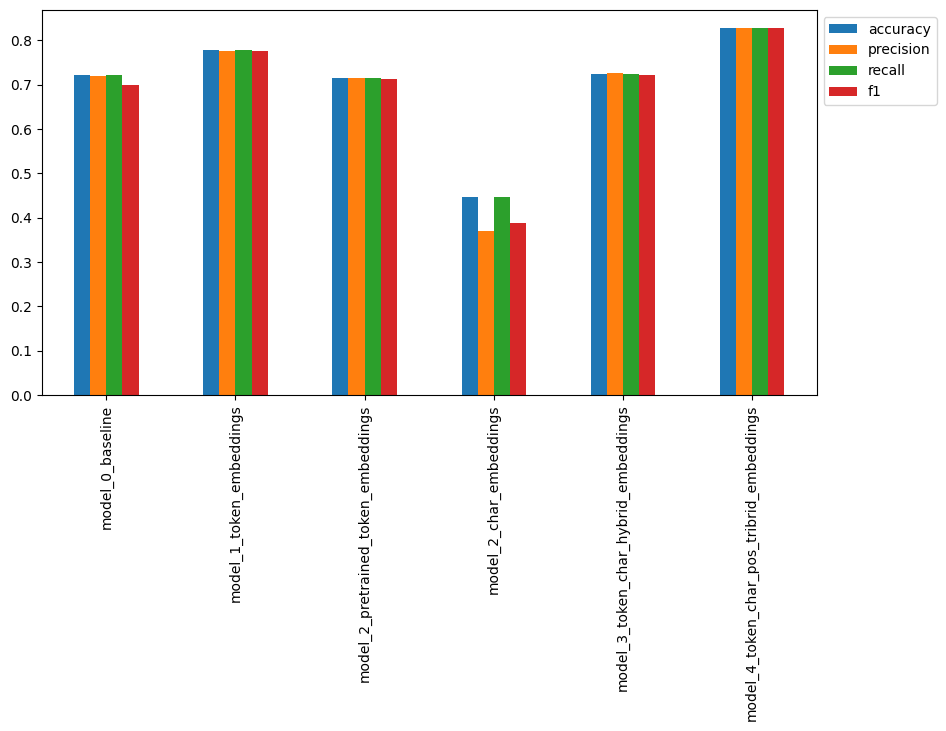

In [121]:
# Visualizing the all models results
all_model_results.plot(kind='bar', figsize=(10, 5)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

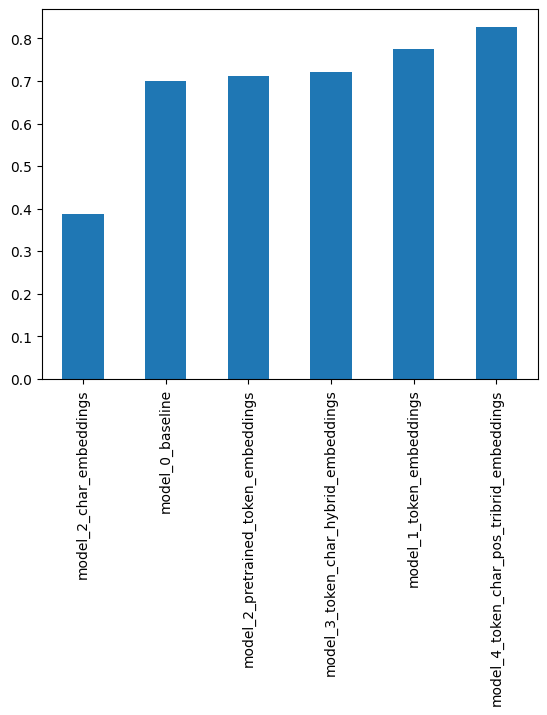

In [122]:
# Visualizing all models for F1 score
all_model_results.sort_values(by=['f1'],ascending=True)['f1'].plot(kind= 'bar')

## Saving and Loading the Model

In [123]:
model_5.save_weights("SkimLit_tribrid_model_weights.h5")

In [124]:
model_5.load_weights('SkimLit_tribrid_model_weights.h5')

In [125]:
test_preds = model_5.predict(test_token_char_pos_dataset)
test_preds = tf.argmax(test_preds, axis =1)
test_preds

942/942 [==============================] - 23s 24ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [126]:
calculate_results(test_labels_encoded, test_preds)

{'accuracy': 82.4390243902439,
 'precision': 0.8239692014804252,
 'recall': 0.824390243902439,
 'f1': 0.823934348925897}

## Final Model

Running the model with 100 epochs with complete train and validation data with Early Stopping technique

In [127]:
# 1. Token Inputs
token_inputs = tf_keras.layers.Input(shape=[], dtype=tf.string, name = 'token_inputs')
token_embeddings = use_embedding_layer(token_inputs)
token_outputs = tf_keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf_keras.Model(token_inputs, token_outputs)

In [128]:
# 2. Char Inputs
char_inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string, name = 'char_inputs')
char_vectors = tf_keras.layers.Lambda(lambda x : char_tokenizer(x))(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(24))(char_embeddings)
char_model = tf_keras.Model(char_inputs, char_bi_lstm)

In [129]:
# 3. Line Numbers Models
line_number_inputs = tf_keras.layers.Input(shape=(15,), dtype = tf.float32, name='line_number_inputs')
line_number_dense = tf_keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf_keras.Model(line_number_inputs, line_number_dense)

In [130]:
# 4. Total Line Models
total_line_number_inputs = tf_keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_line_number_inputs')
total_line_number_dense = tf_keras.layers.Dense(32, activation='relu')(total_line_number_inputs)
total_line_number_model = tf_keras.Model(total_line_number_inputs, total_line_number_dense)

In [131]:
# 5. Combining token and char embedding into hybrid embedding
token_output = token_model(token_inputs)
char_output = char_model(char_inputs)
combined_embeddings = tf_keras.layers.Concatenate(name='char_token_hybrid_embedding')([token_output, char_output])

In [132]:
z = tf_keras.layers.Dense(256, activation='relu')(combined_embeddings)
z = tf_keras.layers.Dropout(0.5)(z)

In [133]:
# 6. Combining the positional embeddings with hybrid embeddings
line_number_output = line_number_model(line_number_inputs)
total_lines_output = total_line_number_model(total_line_number_inputs)
tribrid_embeddings = tf_keras.layers.Concatenate(name='tribrid_embeddings')([line_number_output, total_lines_output, z])

In [134]:
# 7. Create Output layer
output_layer = tf_keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

In [135]:
# 8. Put together model with all kinds of inputs
final_model = tf_keras.Model(inputs = [line_number_inputs, total_line_number_inputs, token_inputs, char_inputs],
outputs = output_layer,
name='tribrid_embedding_final_model')

In [136]:
final_model.summary()

Model: "tribrid_embedding_final_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 model_7 (Functional)        (None, 128)                  2568634   ['token_inputs[0][0]']        
                                                          88                                      
                                                                                                  
 model_8 (Functional)        (None, 48)                   9600      ['

In [138]:
early_stopping = tf_keras.callbacks.EarlyStopping(patience=5, monitor = 'val_accuracy', mode='max')

def custom_lr_schedule(step, initial_lr=0.0005, decay_rate=0.0001, decay_steps=3, steps_per_epoch=None):
    initial_lr = tf.cast(initial_lr, tf.float32)
    decay_rate = tf.cast(decay_rate, tf.float32)
    decay_steps = tf.cast(decay_steps, tf.float32)
    steps_per_epoch = tf.cast(steps_per_epoch, tf.float32)

    epoch = tf.cast(step, tf.float32) / steps_per_epoch
    decay_factor = tf.floor(epoch / decay_steps)
    return tf.maximum(initial_lr - (decay_factor * decay_rate), 1e-6)

class CustomLearningRateSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=0.0005, decay_rate=0.0001, decay_steps=3, steps_per_epoch=None):
        super(CustomLearningRateSchedule, self).__init__()
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.steps_per_epoch = steps_per_epoch

    def __call__(self, step):
        return custom_lr_schedule(
            step,
            self.initial_lr,
            self.decay_rate,
            self.decay_steps,
            self.steps_per_epoch
        )

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_rate": self.decay_rate,
            "decay_steps": self.decay_steps,
            "steps_per_epoch": self.steps_per_epoch,
        }

# Assuming you know the number of steps per epoch
steps_per_epoch = len(train_token_char_pos_dataset)

# Create the learning rate schedule
lr_schedule = CustomLearningRateSchedule(steps_per_epoch=steps_per_epoch)

# Create the Adam optimizer with the custom learning rate schedule
optimizer = tf_keras.optimizers.Adam(learning_rate=lr_schedule)

# Use the optimizer in model.compile()
final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [139]:
final_model_history = final_model.fit(train_token_char_pos_dataset,
epochs = 200,
validation_data = val_token_char_pos_dataset,
callbacks = [early_stopping])

Epoch 1/200
5627/5627 [==============================] - 277s 48ms/step - loss: 0.5205 - accuracy: 0.8021 - val_loss: 0.4032 - val_accuracy: 0.8435
Epoch 2/200
5627/5627 [==============================] - 267s 48ms/step - loss: 0.3926 - accuracy: 0.8511 - val_loss: 0.3688 - val_accuracy: 0.8566
Epoch 3/200
5627/5627 [==============================] - 265s 47ms/step - loss: 0.3609 - accuracy: 0.8636 - val_loss: 0.3558 - val_accuracy: 0.8621
Epoch 4/200
5627/5627 [==============================] - 286s 51ms/step - loss: 0.3370 - accuracy: 0.8739 - val_loss: 0.3497 - val_accuracy: 0.8648
Epoch 5/200
5627/5627 [==============================] - 265s 47ms/step - loss: 0.3240 - accuracy: 0.8789 - val_loss: 0.3485 - val_accuracy: 0.8644
Epoch 6/200
5627/5627 [==============================] - 274s 49ms/step - loss: 0.3124 - accuracy: 0.8833 - val_loss: 0.3502 - val_accuracy: 0.8642
Epoch 7/200
5627/5627 [==============================] - 273s 48ms/step - loss: 0.2979 - accuracy: 0.8889 - val_

KeyboardInterrupt: 

In [140]:
final_model.save_weights("/content/drive/MyDrive/SkimLit/SkimLit_tribrid_model_weights.h5")

In [143]:
final_model.evaluate(val_token_char_pos_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.3622 - accuracy: 0.8669


[0.362198144197464, 0.8669071793556213]

In [144]:
final_model_preds = final_model.predict(val_token_char_pos_dataset)
final_model_preds = tf.argmax(final_model_preds, axis =1)
final_model_preds

945/945 [==============================] - 24s 26ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [146]:
final_model_results = calculate_results(val_labels_encoded, final_model_preds)
final_model_results

{'accuracy': 86.69071891963458,
 'precision': 0.8671713296083648,
 'recall': 0.8669071891963458,
 'f1': 0.8651939012747302}

In [147]:
# Combine the model results into DataFrame
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
'model_1_token_embeddings': model_1_results,
'model_2_pretrained_token_embeddings': model_2_results,
'model_2_char_embeddings': model_3_results,
'model_3_token_char_hybrid_embeddings': model_4_results,
'model_4_token_char_pos_tribrid_embeddings': model_5_results,
'final_model_token_char_pos_tribrid_embeddings': final_model_results
})

all_model_results = all_model_results.transpose()

In [148]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_token_embeddings,77.925990,0.775556,0.779260,0.776260
model_2_pretrained_token_embeddings,71.541109,0.715889,0.715411,0.712444
model_2_char_embeddings,44.644512,0.369795,0.446445,0.387506
model_3_token_char_hybrid_embeddings,72.431484,0.726404,0.724315,0.721268
model_4_token_char_pos_tribrid_embeddings,82.745267,0.826942,0.827453,0.827019
final_model_token_char_pos_tribrid_embeddings,86.690719,0.867171,0.866907,0.865194


In [150]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

In [182]:
import plotly.graph_objects as go

fig = go.Figure()

for column in all_model_results.columns:
    fig.add_trace(go.Bar(
        x=['Baseline_MultinomialNB_Model', 'Token_Embeddings_Model', 'Pretrained_Token_Embeddings_Model', 'Character_Level_Embeddings_Model', 'Hybrid_Model', 'Tribrid_Model',
           'Tribrid_Model_full_data'],
        y=all_model_results[column],
        name=column,
        text=all_model_results[column].round(2),  # Round to 2 decimal places
        textposition='outside',  # Place the text outside the bars
        textangle=0,  # Horizontal text
        cliponaxis=False,  # Allow text to be displayed outside the plot area
        width=0.2,  # Further reduce the width of each bar
        textfont=dict(size=12, color='black', family='Arial, sans-serif', weight='bold')  # Bold data labels
    ))

fig.update_layout(
    title={
        'text': 'Models Results Comparison',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='black', family='Arial, sans-serif', weight='bold')
    },
    xaxis_title='Models',
    yaxis_title='Evaluation metrics',
    barmode='group',
    bargap=0.4,  # Increase space between bar groups
    bargroupgap=0.1,  # Adjust space between bars in a group
    legend=dict(
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top'
    ),
    width=2000,
    height=1000,
    uniformtext_minsize=8,  # Minimum text size
    uniformtext_mode='hide'  # Hide labels if they don't fit
)

# Adjust margins to ensure labels are visible
fig.update_layout(margin=dict(t=100, b=100, l=50, r=50))  # Increased bottom margin for x-axis labels

# Ensure x-axis ticks are not rotated and all are visible
fig.update_xaxes(tickangle=45, automargin=True)  # Rotate labels for better fit

fig.show()

In [194]:
sorted_results = all_model_results.sort_values(by=['f1'], ascending=True)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Character_Level_Embeddings_Model', 'Baseline_MultinomialNB_Model', 'Pretrained_Token_Embeddings_Model', 'Hybrid_Model', 'Token_Embeddings_Model',  'Tribrid_Model', 'Tribrid_Model_full_data'],
    y=sorted_results['f1'],
    text=sorted_results['f1'].round(2),  # Display f1 scores on bars
    textposition='outside',
    cliponaxis=False,
    textfont=dict(size=16, color='black', family='Arial, sans-serif', weight='bold')
))

fig.update_layout(
    title={
        'text': 'Models F1 Scores Comparison',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='black', family='Arial, sans-serif', weight='bold')
    },
    xaxis_title='Models',
    yaxis_title='F1 Score',
    xaxis_tickangle=45,  # Angle the x-axis labels for better readability
    margin=dict(t=100, b=100, l=50, r=50),  # Adjust margins
    height=1000,
    width=1400
)

# Show the plot
fig.show()

## Making Predictions on Test data

In [196]:
final_model_test_preds = final_model.predict(test_token_char_pos_dataset)
final_model_test_preds = tf.argmax(final_model_test_preds, axis =1)
final_model_test_preds

942/942 [==============================] - 23s 24ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [197]:
final_model_test_results = calculate_results(test_labels_encoded, final_model_test_preds)
final_model_test_results

{'accuracy': 86.14567778330844,
 'precision': 0.8611004826471863,
 'recall': 0.8614567778330845,
 'f1': 0.8596446408695304}

## Conclusion:

Final tribrid model with predictions on the test data is perfomed and obtained `Accuracy`: **0.8614**, `Precision`: **0.8611** , `Recall`: **0.8614** & `F1-score`: **0.8596**